In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
# import pyflux as pf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import arch
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller


from data.stock_data import StockData


In [2]:
# Define the stock data you want to fetch, and fetch it
# Ticker for yahoo finance sp500 data
ticker = '^GSPC'
start_date = '2006-01-01'
end_date='2022-12-31'

sp500 = StockData(ticker, start_date, end_date).fetch_data()

# Drop all the rows where Log Return is exactly 0
sp500 = sp500[sp500['Log Return'] != 0]
sp500 = sp500.dropna()
sp500

[*********************100%***********************]  1 of 1 completed


,Log Return,Squared Return
Date,,
2006-01-04,0.366596,0.134393
2006-01-05,0.001572,0.000002
2006-01-06,0.935552,0.875257
2006-01-09,0.364970,0.133203
2006-01-10,-0.035668,0.001272
...,...,...
2022-12-23,0.585095,0.342336
2022-12-27,-0.405784,0.164661
2022-12-28,-1.209347,1.462520


In [3]:
# Import macro data
macro_df = pd.read_csv('data/macro_data.csv')
macro_df

,Year-Month,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
0,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
1,2006-02,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
2,2006-03,4.515,0.338,0.006086,0.085002,3.362649,-0.020833
3,2006-04,4.650,0.419,-0.002866,0.078793,3.545735,0.000000
4,2006-05,4.715,0.398,-0.017775,-0.008208,4.166667,-0.021277
...,...,...,...,...,...,...,...
206,2023-03,4.585,-1.091,0.005933,-0.017911,4.984974,-0.027778
207,2023-04,4.923,-1.471,-0.008239,0.014669,4.930320,-0.028571
208,2023-05,5.248,-1.611,0.007552,-0.113181,4.047609,0.088235
209,2023-06,5.153,-1.334,0.004591,0.037450,2.969178,-0.027027


In [4]:
# Calculate the monthly RV for log returns
sp500['RV'] = sp500['Squared Return'].resample('M').sum()
# Backward fill the nans in RV
sp500['RV'] = sp500['RV'].fillna(method='bfill')
sp500 = sp500.dropna()
sp500.head()

,Log Return,Squared Return,RV
Date,,,
2006-01-04,0.366596,0.134393,7.100696
2006-01-05,0.001572,0.000002,7.100696
2006-01-06,0.935552,0.875257,7.100696
2006-01-09,0.364970,0.133203,7.100696
2006-01-10,-0.035668,0.001272,7.100696


In [5]:
# Merge the hf stock data with lf macro data based on the month
sp500.index = pd.to_datetime(sp500.index)
macro_df['Year-Month'] = pd.to_datetime(macro_df['Year-Month'])
sp500['YearMonth'] = sp500.index.to_period('M')
macro_df['YearMonth'] = macro_df['Year-Month'].dt.to_period('M')
macro_df.drop('Year-Month', axis=1, inplace=True)
sp500.reset_index(inplace=True)
merged_df = pd.merge(sp500, macro_df, on='YearMonth', how='left')
merged_df.set_index('Date', inplace=True)

/tmp/ipykernel_102964/4269270028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['YearMonth'] = sp500.index.to_period('M')


In [6]:
merged_df

,Log Return,Squared Return,RV,YearMonth,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
Date,,,,,,,,,,
2006-01-04,0.366596,0.134393,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-05,0.001572,0.000002,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-06,0.935552,0.875257,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-09,0.364970,0.133203,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-10,-0.035668,0.001272,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0.589727,0.347777,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,-0.027027
2022-11-25,-0.028308,0.000801,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,-0.027027
2022-11-28,-1.556470,2.422598,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,-0.027027


### Create pricipal components from macro data

In [7]:
# Features list should include everything else than Log Return	Squared Return	RV	YearMonth
# Get all column names from merged_df
all_cols = merged_df.columns.tolist()

# Define the columns to exclude from features list
exclude_cols = ['Log Return', 'Squared Return', 'RV', 'YearMonth']

# Create the features list
features = [col for col in all_cols if col not in exclude_cols]

# Print the features list
display(features)

# Separating out the features
x = merged_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

x

['3 Month T-Bill Rate',
 'Yield Curve Slope',
 'Reer Change',
 'Change Oil Price',
 'CPI',
 'Unemployment Rate Change']

array([[ 2.19038799, -1.36853212, -0.80469459,  0.89304965,  0.78227513,
        -0.27023468],
       [ 2.19038799, -1.36853212, -0.80469459,  0.89304965,  0.78227513,
        -0.27023468],
       [ 2.19038799, -1.36853212, -0.80469459,  0.89304965,  0.78227513,
        -0.27023468],
       ...,
       [ 2.11289884, -2.04489733, -2.03030985, -0.64838149,  2.33211929,
        -0.1889285 ],
       [ 2.11289884, -2.04489733, -2.03030985, -0.64838149,  2.33211929,
        -0.1889285 ],
       [ 2.11289884, -2.04489733, -2.03030985, -0.64838149,  2.33211929,
        -0.1889285 ]])

In [8]:
# Create principal components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [9]:
merged_df = (merged_df.reset_index()
                      .join(principalDf, how='right')
                      .set_index('Date'))

merged_df

,Log Return,Squared Return,RV,YearMonth,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change,principal component 1,principal component 2
Date,,,,,,,,,,,,
2006-01-04,0.366596,0.134393,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.727862,1.011307
2006-01-05,0.001572,0.000002,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.727862,1.011307
2006-01-06,0.935552,0.875257,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.727862,1.011307
2006-01-09,0.364970,0.133203,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.727862,1.011307
2006-01-10,-0.035668,0.001272,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.727862,1.011307
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0.589727,0.347777,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,-0.027027,3.733578,0.452006
2022-11-25,-0.028308,0.000801,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,-0.027027,3.733578,0.452006
2022-11-28,-1.556470,2.422598,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,-0.027027,3.733578,0.452006


In [10]:
sp500_returns = sp500[['Log Return', 'Squared Return']]
sp500_returns

,Log Return,Squared Return
0,0.366596,0.134393
1,0.001572,0.000002
2,0.935552,0.875257
3,0.364970,0.133203
4,-0.035668,0.001272
...,...,...
4250,0.589727,0.347777
4251,-0.028308,0.000801
4252,-1.556470,2.422598
4253,-0.159313,0.025381


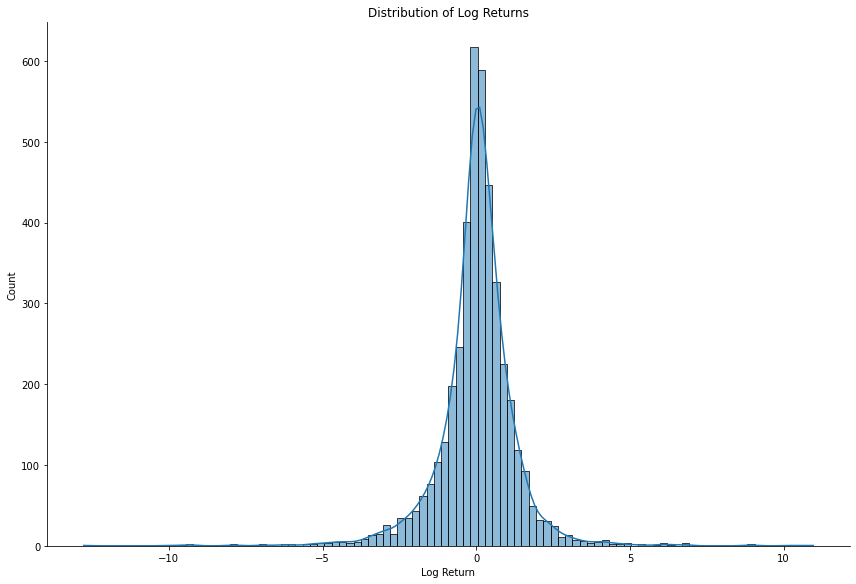

count    4255.000000
mean        0.027451
std         1.274066
min       -12.765220
25%        -0.412652
50%         0.070885
75%         0.574832
max        10.957197
Name: Log Return, dtype: float64
Skewness (Log Returns):  -0.5238087845692488
Kurtosis (Log Returns):  12.343843390702974


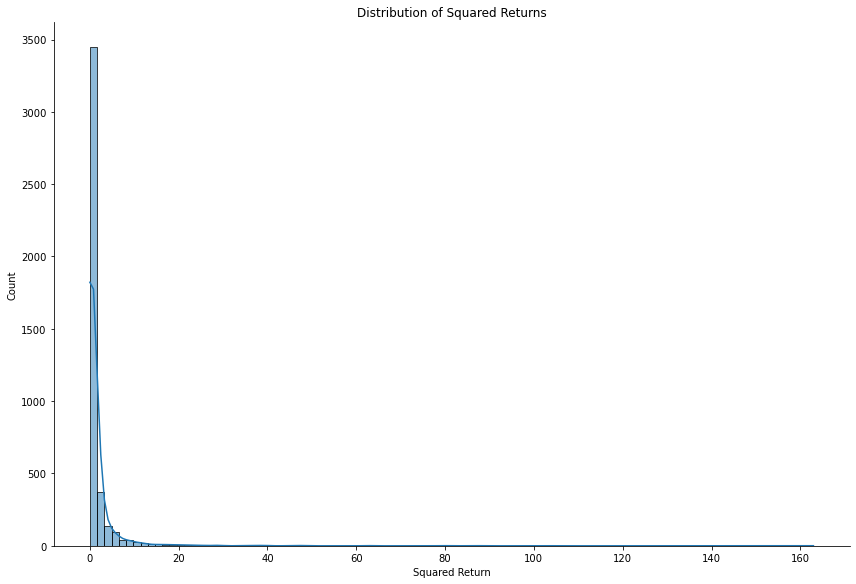

count    4.255000e+03
mean     1.623617e+00
std      6.137755e+00
min      2.645383e-07
25%      4.265120e-02
50%      2.602126e-01
75%      1.119490e+00
max      1.629508e+02
Name: Squared Return, dtype: float64
Skewness (Squared Returns):  12.77022852438828
Kurtosis (Squared Returns):  227.5072769241876


In [11]:
"""
# Descriptive statistics for daily returns
print(sp500['Daily Return'].describe())

# Plotting the distribution of daily returns
sns.displot(sp500['Daily Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Daily Returns')
plt.show()

# Skewness and kurtosis for daily returns
print('Skewness (Daily Returns): ', skew(sp500['Daily Return'].dropna()))
print('Kurtosis (Daily Returns): ', kurtosis(sp500['Daily Return'].dropna()))
"""

# Plotting the distribution of log returns
sns.displot(sp500['Log Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Log Returns')
plt.show()

# Descriptive statistics for log returns
print(sp500['Log Return'].describe())

# Skewness and kurtosis for log returns
print('Skewness (Log Returns): ', skew(sp500['Log Return'].dropna()))
print('Kurtosis (Log Returns): ', kurtosis(sp500['Log Return'].dropna()))

# Plotting the distribution of squared returns
sns.displot(sp500['Squared Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Squared Returns')
plt.show()

# Descriptive statistics for squared returns
print(sp500['Squared Return'].describe())

# Skewness and kurtosis for squared returns
print('Skewness (Squared Returns): ', skew(sp500['Squared Return'].dropna()))
print('Kurtosis (Squared Returns): ', kurtosis(sp500['Squared Return'].dropna()))


In [12]:
# Find the date of highest squared return in sp500
sp500.sort_values(ascending=False, by='Squared Return')


,Date,Log Return,Squared Return,RV,YearMonth
3570,2020-03-16,-12.765220,1.629508e+02,747.387178,2020-03
697,2008-10-13,10.957197,1.200602e+02,573.012830,2008-10
708,2008-10-28,10.245736,1.049751e+02,573.012830,2008-10
3568,2020-03-12,-9.994485,9.988974e+01,747.387178,2020-03
699,2008-10-15,-9.469512,8.967167e+01,573.012830,2008-10
...,...,...,...,...,...
208,2006-10-31,0.000718,5.149116e-07,4.478843,2006-10
3204,2018-09-28,-0.000687,4.719888e-07,46.390647,2018-09
1774,2013-01-24,0.000661,4.375375e-07,8.897690,2013-01
1836,2013-04-24,0.000634,4.019776e-07,16.922038,2013-04


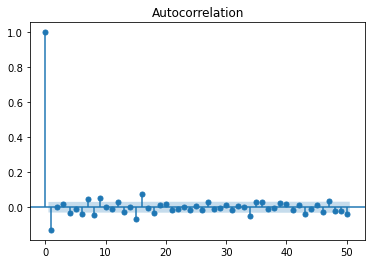

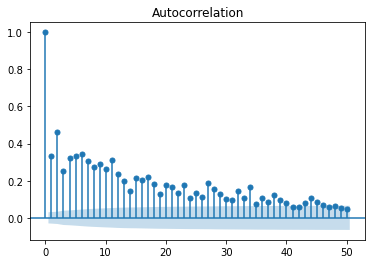

In [13]:
# Plot the autocorrelation of the returns
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sp500['Log Return'].dropna(), lags=50)
plt.show()

# Now, plot the autocorrelation of squared returns

plot_acf(sp500['Squared Return'].dropna(), lags=50)
plt.show()


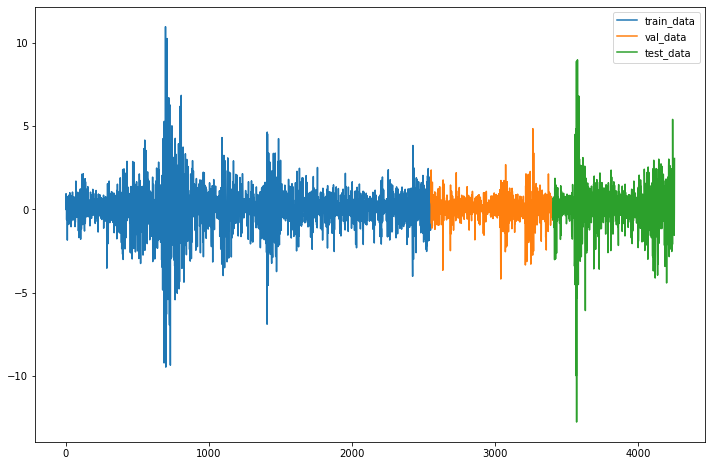

In [21]:

# Split sp500_returns into a train, validation and test set with the weights 0.6, 0.2, 0.2
train_data = sp500[:int(len(sp500)*0.6)]
val_data = sp500[int(len(sp500)*0.6):int(len(sp500)*0.8)]
test_data = sp500[int(len(sp500)*0.8):]

# Plot the train_data, val_data and test_data sets
plt.figure(figsize=(12, 8))
plt.plot(train_data['Log Return'], label='train_data')
plt.plot(val_data['Log Return'], label='val_data')
plt.plot(test_data['Log Return'], label='test_data')
plt.legend()
plt.show()

In [15]:
# Perform an ADF test on the data
adf_result = adfuller(sp500['Log Return'].dropna())

# adf test value and p-value
adf, p_value, *_ = adf_result

# Print out adf and its p-value
print(f'ADF Statistic: {adf}')
print(f'p-value: {p_value}')

ADF Statistic: -15.66194057504551
p-value: 1.5501168881168429e-28


### VIsualizing low frequency data

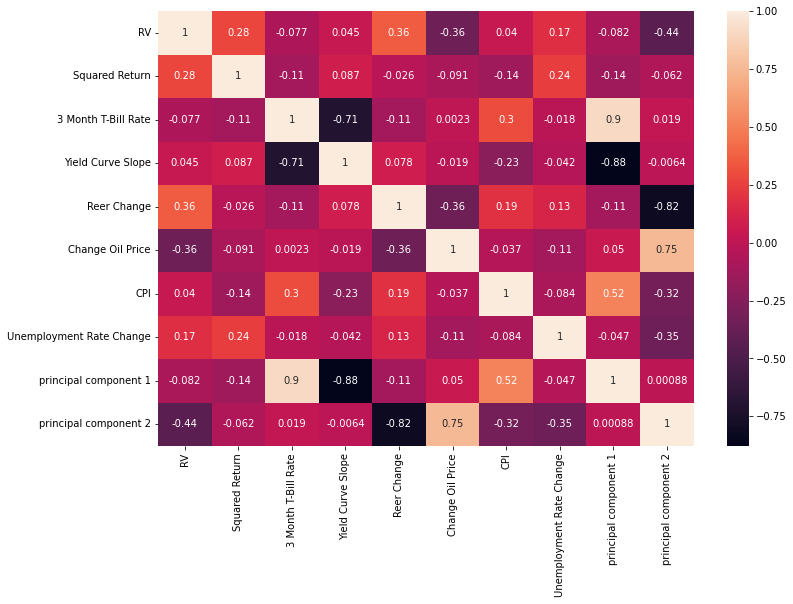

In [16]:
visualization_df = merged_df[features + ['principal component 1', 'principal component 2', 'YearMonth', 'RV', 'Squared Return']]

# Take only one row of each YearMonth
visualization_df = visualization_df.groupby('YearMonth').first()

# Visualize the correlation, make RV the first column row
visualization_df = visualization_df[['RV', 'Squared Return'] + features + ['principal component 1', 'principal component 2']]
visualization_df

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(visualization_df.corr(), annot=True)
plt.show()

In [ ]:
# Create a GARCH(1, 1) model, first train it on train data, then test on test data
from arch import arch_model

# Assuming 'train_data' and 'test_data' have been previously defined, as per your data split
# and 'Log Return' is the column we want to model

# Define the GARCH(1,1) model
garch11 = arch_model(train_data['Log Return'], vol='Garch', p=1, q=1)

# Fit the model
res = garch11.fit(update_freq=10)

# Display the model fitting results
print(res.summary())

# Make predictions on the test set
test_pred = res.forecast(horizon=len(test_data['Log Return']))

# The .variance property returns the conditional variance (the square of the volatilities)
predicted_variance = test_pred.variance.iloc[-1]

# Since GARCH models the volatility (standard deviation), you may want to take the square root of the variance to get the predicted volatilities
predicted_volatility = predicted_variance.apply(np.sqrt)

# To evaluate the predictions, you could compare these predicted volatilities to the actual volatilities in the test set
# However, GARCH only models volatility, not the returns themselves. For actual returns, you'd need to make assumptions or use a different model.

# You might want to plot the predicted volatilities alongside the actual volatilities to visually assess the model's performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Log Return']**2, label='Actual Variance')
plt.plot(predicted_volatility.index, predicted_volatility, label='Predicted Volatility', alpha=0.7)
plt.legend()
plt.show()

